In [738]:
import pandas as pd
import numpy as np
import re

def get_top_entity(entry):
    return entry.split(',')[0]

def paranthesis_remover(entry):
    return re.sub('\(.+?\)', '', str(entry))

def one_hot_encoder(file_name):
    imdb_df = pd.read_csv(file_name)
    
    # Include only movies, and successful API calls
    reduced_imdb = imdb_df.loc[imdb_df['Response'] == True]
    reduced_imdb = imdb_df.loc[imdb_df['Type'] == 'movie']
    
    # drop extra columns
    reduced_imdb.columns = map(str.lower, reduced_imdb.columns)
    return reduced_imdb.drop(columns=['dvd', 'unnamed: 0', 'awards',
                                      'plot', 'error', 'poster',
                                      'rated', 'ratings', 'response',
                                      'type', 'website', 'imdbid', 'totalseasons'])
    

In [739]:
imdb = one_hot_encoder('./raw_data/combined_imdb_data.csv')

In [740]:
# Get IMDB movie metadata
# script_csv_path = "/content/drive/My Drive/ENSF 519/Data/combined_imdb_data.csv"
imdb_csv_path = "./raw_data/combined_imdb_data.csv"
imdb_data = pd.read_csv(imdb_csv_path, index_col=0).rename(columns={"Title": "title"})
# imdb_data = imdb_data.drop(columns=["Awards", "Country", "DVD", "Ratings", "Director"])
# print(imdb_data.columns)
# display(imdb_data)
imdb_data = imdb_data[imdb_data['Response'] == True]
imdb_data = imdb_data[['title', 'BoxOffice', 'Metascore', 'Runtime', 'Year', 'imdbRating', 'imdbVotes']]
imdb_data['BoxOffice'] = imdb_data['BoxOffice'].str.replace(r'[\$\,]', "")
imdb_data['BoxOffice'] = imdb_data['BoxOffice'].str.replace(r'', "0")
imdb_data = imdb_data.fillna(0)
imdb_data['BoxOffice'] = imdb_data['BoxOffice'].astype(float)
imdb_data['Metascore'] = imdb_data['Metascore'].astype(float)
imdb_data['Runtime'] = imdb_data['Runtime'].str.replace(r' min', "")
imdb_data['Runtime'] = imdb_data['Runtime'].astype(float)
imdb_data['Year'] = imdb_data['Year'].str.replace('(\–\d*)', "")
imdb_data['Year'] = imdb_data['Year'].astype(float)
imdb_data['imdbVotes'] = imdb_data['imdbVotes'].str.replace(',', "")
imdb_data['imdbVotes'] = imdb_data['imdbVotes'].astype(float)
# print(imdb_data.dtypes)
# display(imdb_data)

# Get Oscar labels
# oscar_labels_path = "/content/drive/My Drive/ENSF 519/Data/oscar_data.csv"
oscar_labels_path = "./processed_data/oscar_data.csv"
oscar_label = pd.read_csv(oscar_labels_path).rename(columns={"entity": "title", "category": "nominated", "winner": "won"})
oscar_label = oscar_label.drop(columns=["year"])
oscar_label = oscar_label[oscar_label['won'] == True]

# Merge script and Oscar data
imdb_oscar_df = pd.merge(imdb_data, oscar_label, how="outer", on="title")
imdb_oscar_df = imdb_oscar_df.dropna(subset=['BoxOffice'])
imdb_oscar_df = imdb_oscar_df.fillna(False)
imdb_oscar_df['nominated'].astype('bool')
imdb_oscar_df['won'].astype('bool')

# Only choose movies that were nominated and won
imdb_oscar_df = imdb_oscar_df.drop_duplicates()
imdb_oscar_df = imdb_oscar_df.drop(columns=['nominated', 'title'])
imdb_oscar_df['won'] = imdb_oscar_df['won'].astype(int)
imdb_oscar_df = imdb_oscar_df.reset_index(drop=True)

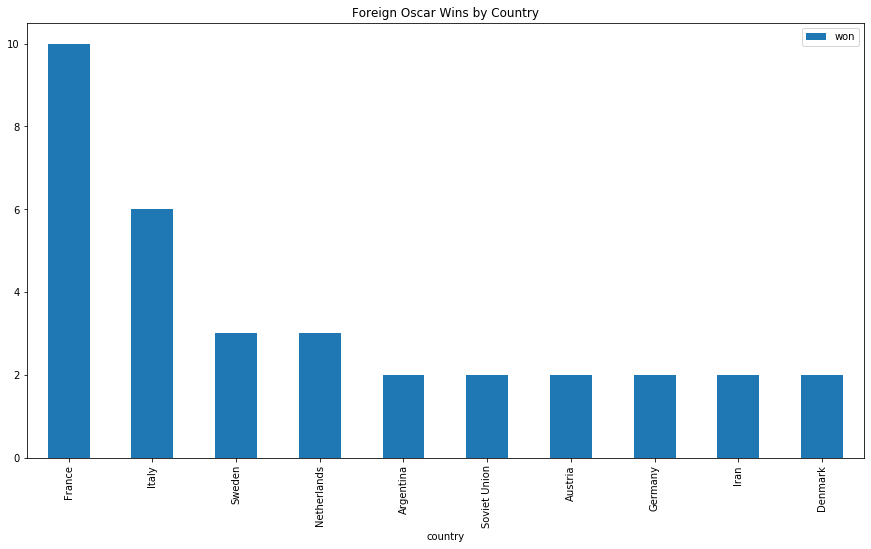

In [741]:
import matplotlib.pyplot as plt

# This is for determining the number of foreign oscar film wins by Foreign countries
def get_top_country(entry):
    return entry.split(',')[0]

def graph_generator(merged_df, aggr_category, title, aggr_func):
    merged_df = merged_df.dropna(subset=[aggr_category])
    merged_df = merged_df.fillna(False)
    merged_df['nominated'].astype('bool')
    merged_df['won'].astype('bool')
    
    merged_df['won'] = merged_df['won'].astype(int)
    merged_df = merged_df.reset_index(drop=True)
    
    merged_df = merged_df[merged_df['won'] == True]
    merged_df[aggr_category] = merged_df[aggr_category].apply(aggr_func)
    merged_group = merged_df.groupby(aggr_category).sum()
    merged_group.reset_index(inplace=True)
    merged_group = merged_group.sort_values('won', ascending=False)
    merged_group = merged_group.nlargest(10, columns=['won'])
    merged_group.plot(x=aggr_category, y='won', kind='bar', title=title, figsize=(15, 8))

foreign_film_oscar_label = oscar_label[oscar_label['nominated'] == 'FOREIGN LANGUAGE FILM']

foreign_oscar_df = pd.merge(imdb, foreign_film_oscar_label, how="outer", on="title")
graph_generator(foreign_oscar_df, 'country', 'Foreign Oscar Wins by Country', get_top_country)


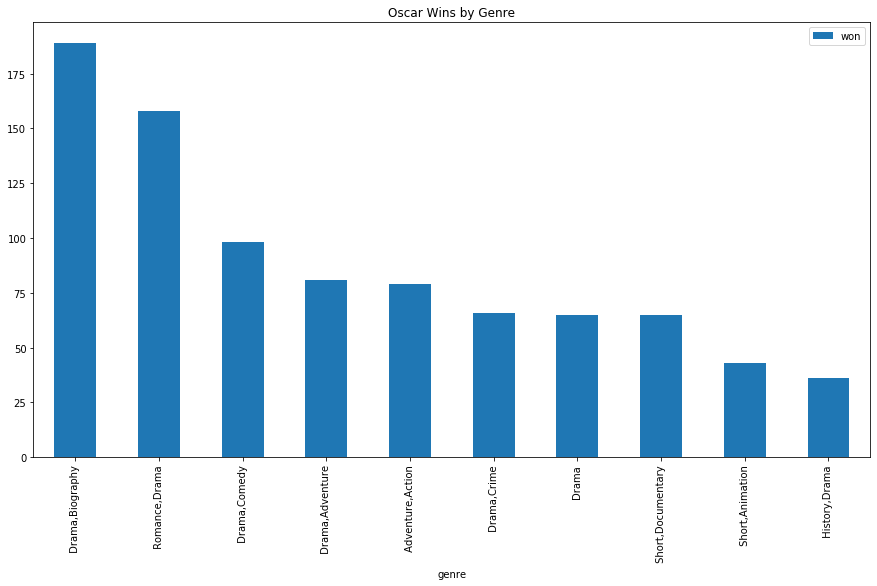

In [742]:
def top_2_genres(entry):
    entry_list = entry.split(',')
    top_2 = entry_list[0:2]
    sorted_top_2 = sorted(top_2)
    return ','.join(sorted_top_2)

genre_df = pd.merge(imdb, oscar_label, how="outer", on="title")
graph_generator(genre_df, 'genre', 'Oscar Wins by Genre', top_2_genres)

In [743]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

pca_oscar_df = pd.merge(imdb_data, oscar_label, how="outer", on="title")
pca_oscar_df = pca_oscar_df.dropna(subset=['BoxOffice'])
pca_oscar_df = pca_oscar_df.fillna(False)
pca_oscar_df['nominated'].astype('bool')
pca_oscar_df['won'].astype('bool')

pca_oscar_df = pca_oscar_df.drop_duplicates()
pca_oscar_df = pca_oscar_df.drop(columns=['nominated', 'title'])
pca_oscar_df['won'] = pca_oscar_df['won'].astype(int)
pca_oscar_df = pca_oscar_df.reset_index(drop=True)

features = pca_oscar_df.drop(columns=['won'])
labels = pca_oscar_df['won']
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=69)
X_train = X_train.dropna()
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train, y_train)

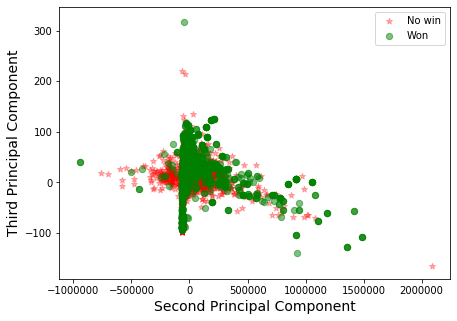

In [744]:
Xax=X_train_pca[:,1]
Yax=X_train_pca[:,2]
labels=y_train
cdict={0:'red',1:'green'}
labl={0:"No win",1:"Won"}
marker={0:'*',1:'o'}
alpha={0:.3, 1:.5}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
    ix=np.where(labels==l)
    ax.scatter(Xax[ix],Yax[ix],c=cdict[l],s=40,
           label=labl[l],marker=marker[l],alpha=alpha[l])
# for loop ends
plt.xlabel("Second Principal Component",fontsize=14)
plt.ylabel("Third Principal Component",fontsize=14)
plt.legend()
plt.show()
# please check the scatter plot of the remaining component and you will understand the difference

C:\Users\Harjee\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  import sys


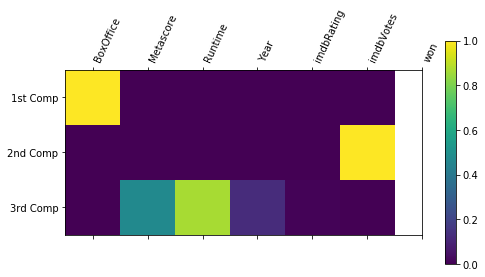

In [745]:
import matplotlib.pyplot as plt

plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1,2],['1st Comp','2nd Comp','3rd Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(imdb_oscar_df.columns)),imdb_oscar_df.columns,rotation=65,ha='left')
plt.tight_layout()
plt.show()

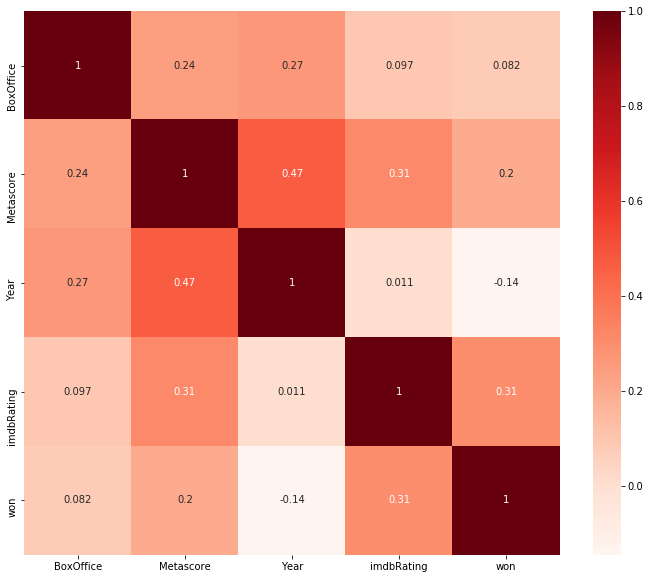

In [746]:
import seaborn as sns


plt.figure(figsize=(12,10))
cor = imdb_oscar_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [747]:
# preprocessing for 'time-series'

fillnavals = {'boxoffice': 0}

def runtime_converter(entry):
    entry = re.sub(' min$', '', str(entry))
    return int(entry)

def release_year_fix(entry):
    if '-' in entry:
        entry_list = entry.split('-')
        year = entry_list[2]
        if year >= '20' and year <= '99':
            year = '19' + year
        else:
            year = '20' + year
        entry_list[2] = year
        
        entry = '-'.join(entry_list)
        
    return entry

imdb.dropna(subset=['actors', 'language', 'genre', 'director', 'writer', 'runtime', 'released'], inplace=True)
imdb.drop(columns=['imdbvotes', 'year', 'metascore', 'imdbrating', 'country'], inplace=True)
imdb['released'] = imdb['released'].apply(release_year_fix)
imdb.index = pd.to_datetime(imdb['released'])

imdb['director'] = imdb['director'].apply(get_top_entity)
imdb['writer'] = imdb['writer'].apply(get_top_entity)
imdb['actors'] = imdb['actors'].apply(get_top_entity)
imdb['genre'] = imdb['genre'].apply(get_top_entity)
imdb['language'] = imdb['language'].apply(get_top_entity)
imdb['writer'] = imdb['writer'].apply(paranthesis_remover)

imdb['runtime'] = imdb['runtime'].apply(runtime_converter)
imdb['boxoffice'] = imdb['boxoffice'].str.replace(r'[\$\,]', "")
imdb.fillna(value=fillnavals, inplace=True)

oscar_labels_path = "./processed_data/oscar_data.csv"
oscar_label = pd.read_csv(oscar_labels_path).rename(columns={"entity": "title", "category": "nominated", "winner": "won"})
oscar_label = oscar_label.drop(columns=["year"])
oscar_label["nominated"] = True

# Merge script and Oscar data
imdb_oscar_df_ts = pd.merge(imdb, oscar_label, how="outer", on="title")
imdb_oscar_df_ts = imdb_oscar_df_ts.dropna(subset=['boxoffice'])
imdb_oscar_df_ts = imdb_oscar_df_ts.fillna(False)
imdb_oscar_df_ts['nominated'].astype('bool')
imdb_oscar_df_ts['won'].astype('bool')

# Only choose movies that were nominated and won
imdb_oscar_df_ts = imdb_oscar_df_ts[imdb_oscar_df_ts['nominated'] == imdb_oscar_df_ts['won']].drop_duplicates()
imdb_oscar_df_ts = imdb_oscar_df_ts.drop(columns=['nominated', 'title'])
imdb_oscar_df_ts['won'] = imdb_oscar_df_ts['won'].astype(int)
imdb_oscar_df_ts.index = pd.to_datetime(imdb_oscar_df_ts['released'])

imdb_oscar_df_ts.drop(columns=['released'], inplace=True)
imdb_ohe = pd.get_dummies(imdb_oscar_df_ts)
imdb_ohe.sort_index(inplace=True)

In [748]:
import datetime
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict

# Random Forest Classification per Decade of Data

feature_importance_per_decade = defaultdict(dict)
rfc = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=0)

starting_date = datetime.date(1930, 1, 1)
ending_date = starting_date.replace(starting_date.year + 10)
current_date = datetime.date.today()

while starting_date <= current_date:
    interval_data = imdb_ohe.loc[imdb_ohe.index >= pd.Timestamp(starting_date)]
    interval_data =  interval_data.loc[interval_data.index < pd.Timestamp(ending_date)]
    features = interval_data.drop(columns=['won'])
    labels = interval_data['won']
    
    rfc.fit(features, labels)
    temp_dict = {}
    for feature, importance in zip(interval_data.columns, rfc.feature_importances_):
        temp_dict[feature] = importance
    feature_importance_per_decade[str(starting_date)] = temp_dict
    
    starting_date = ending_date
    ending_date = starting_date.replace(starting_date.year + 10)
    

In [749]:
import numpy as np
# grab top 10 features per decade

top_of_decade = {}

for key, inner_dict in feature_importance_per_decade.items():
    feature_values = np.asarray(list(inner_dict.values()))
    top_10_feature_indices = feature_values.argsort()[-10:]
    top_10_features = [list(inner_dict.keys())[i] for i in top_10_feature_indices]
    top_10_feature_values = [feature_values[i] for i in top_10_feature_indices]
    
    tuples_top_features = dict(zip(top_10_features, top_10_feature_values))
    top_of_decade[key] = tuples_top_features  

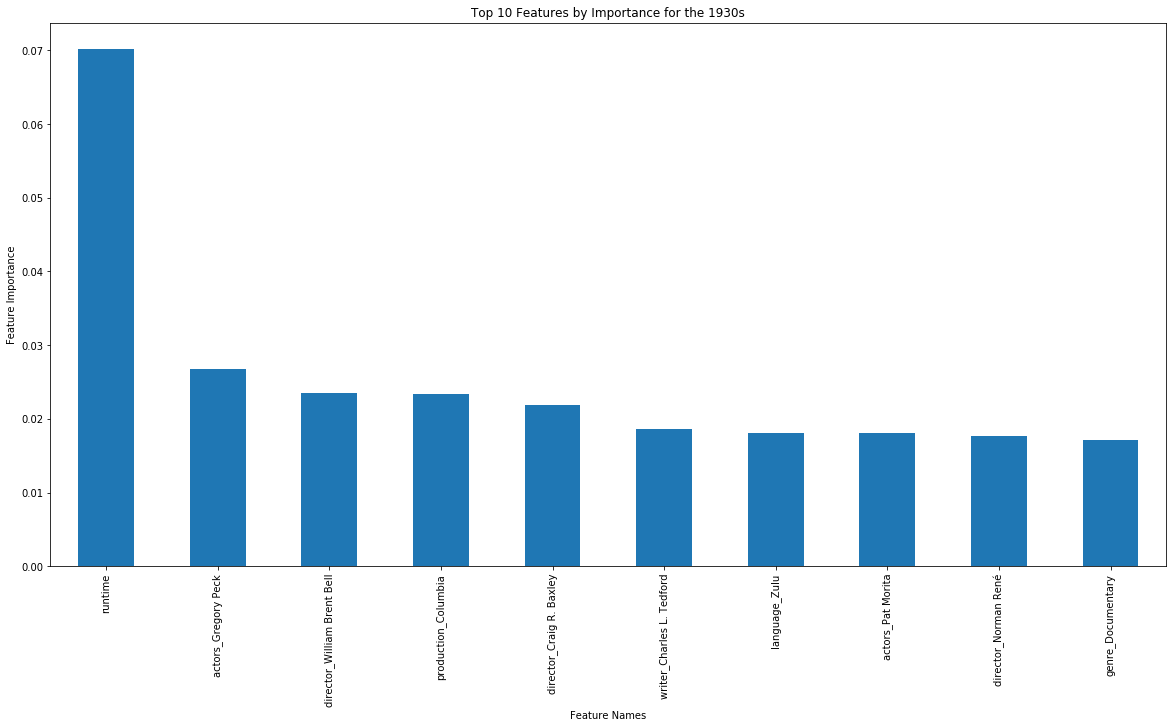

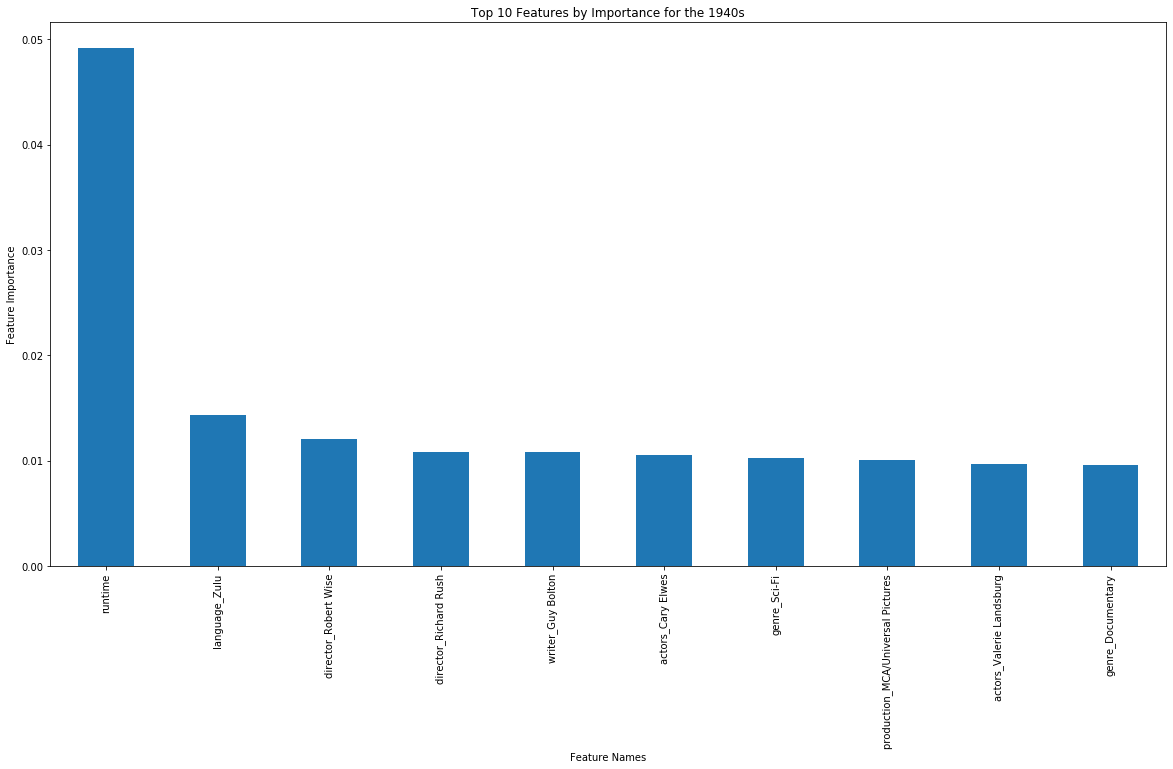

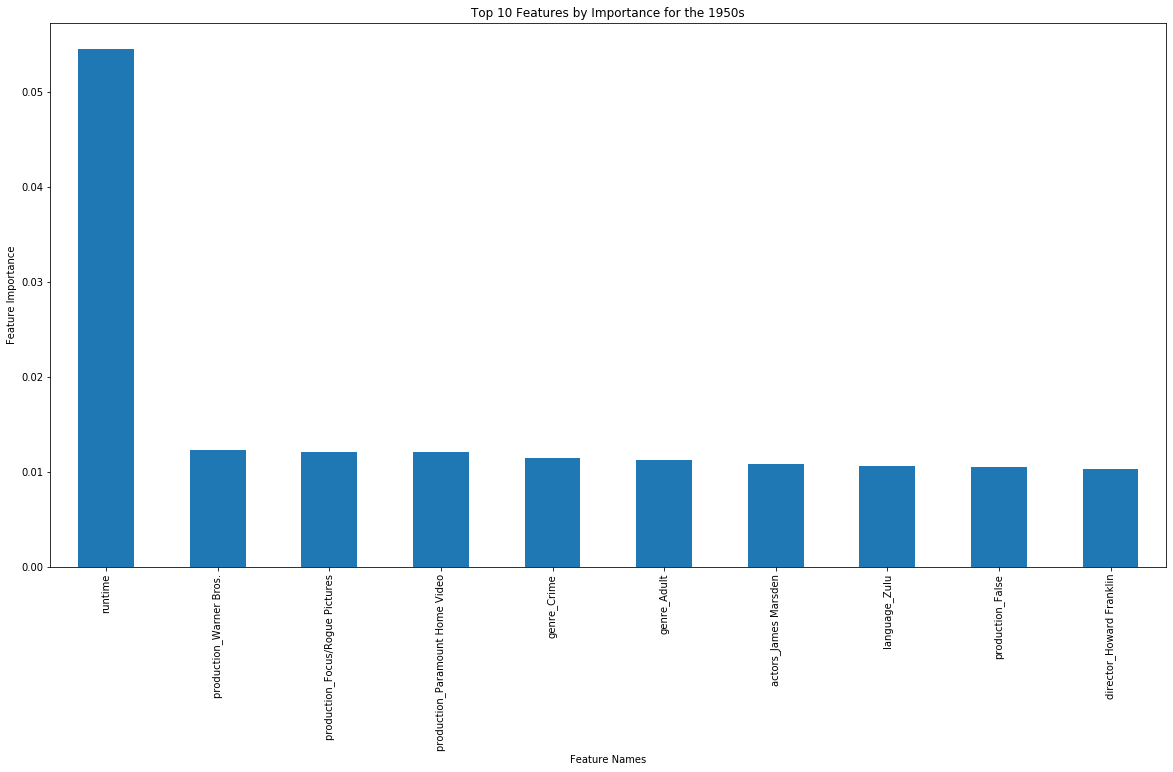

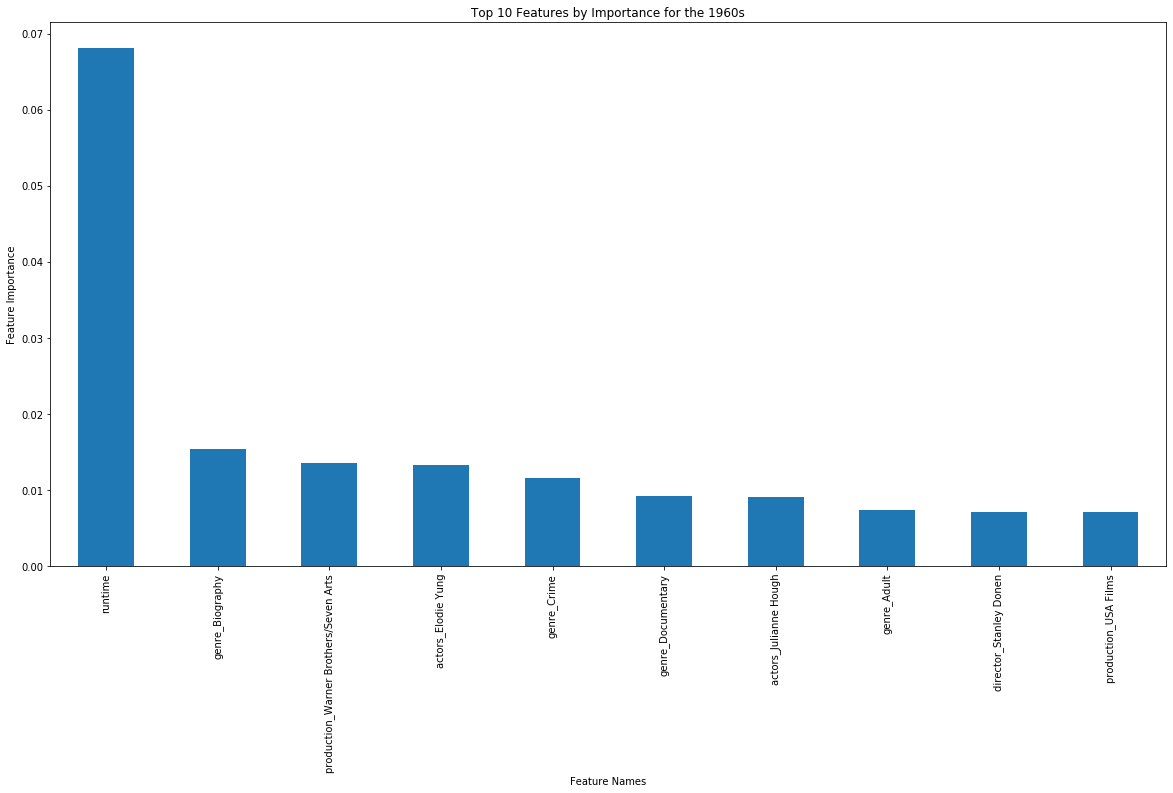

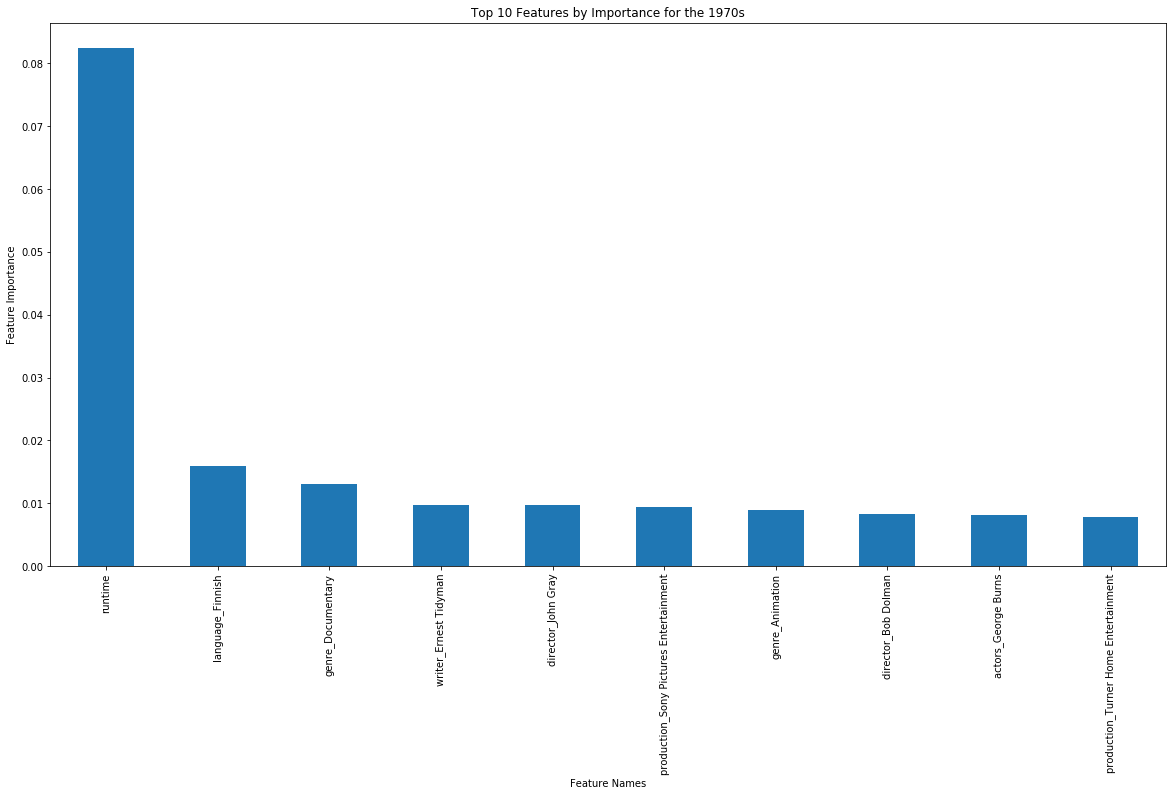

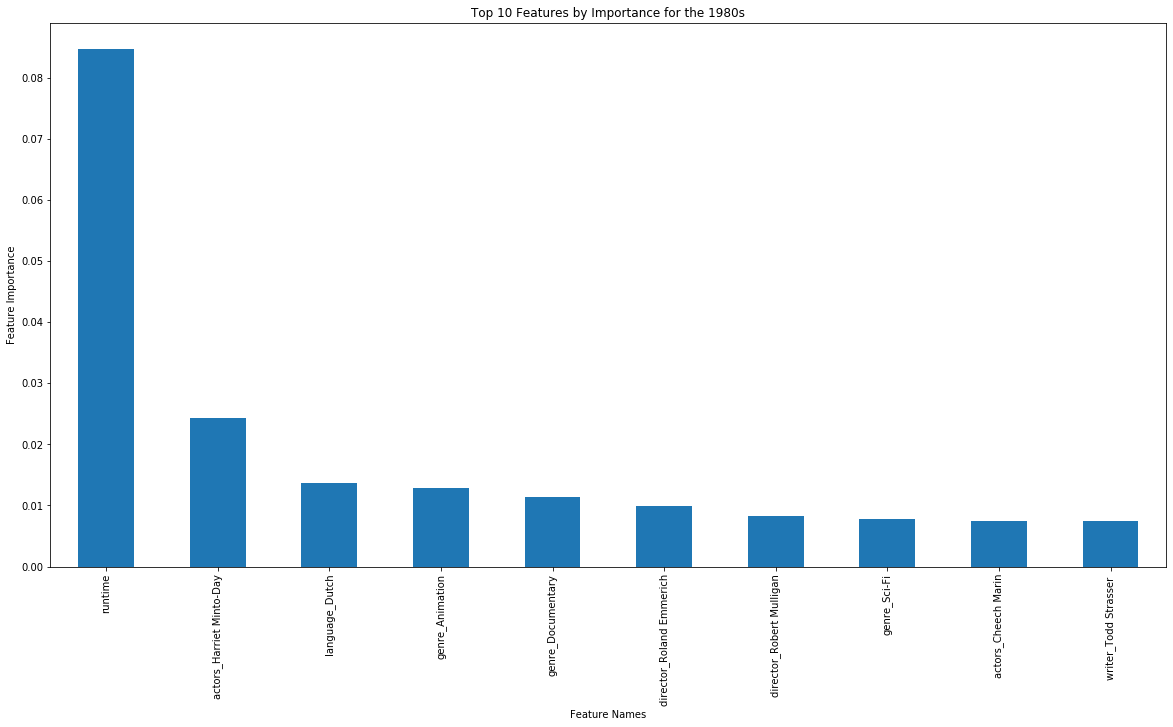

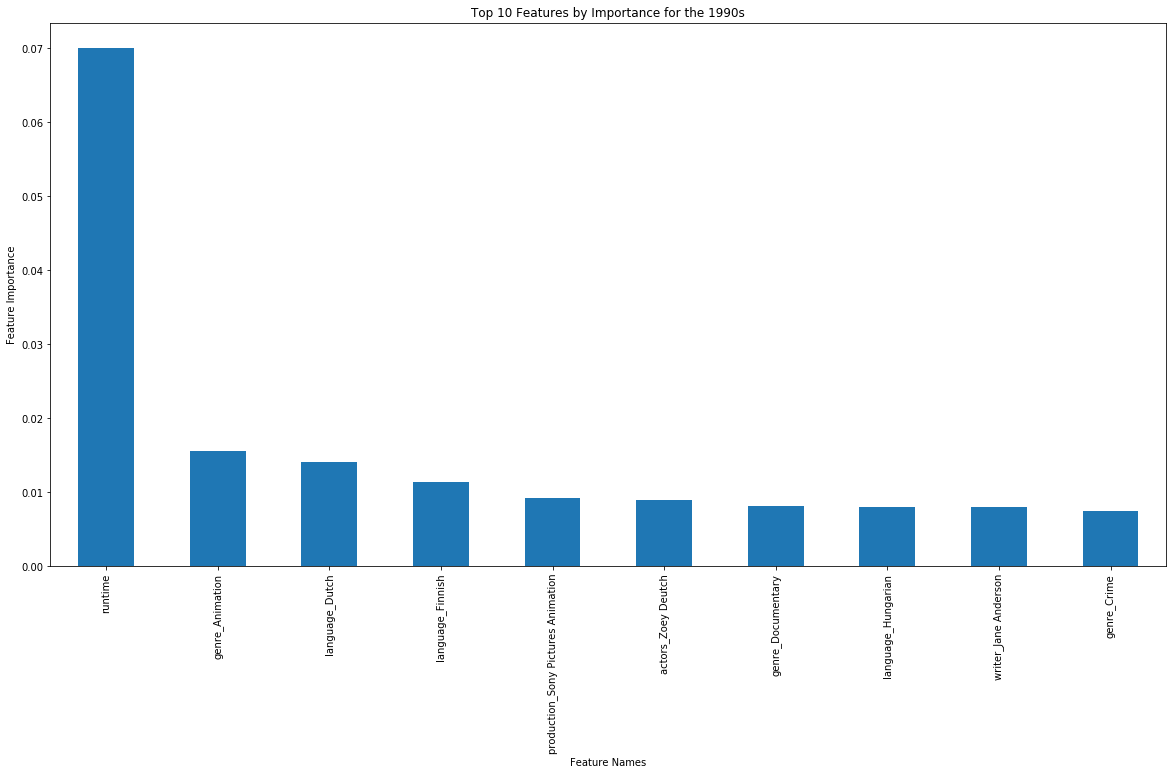

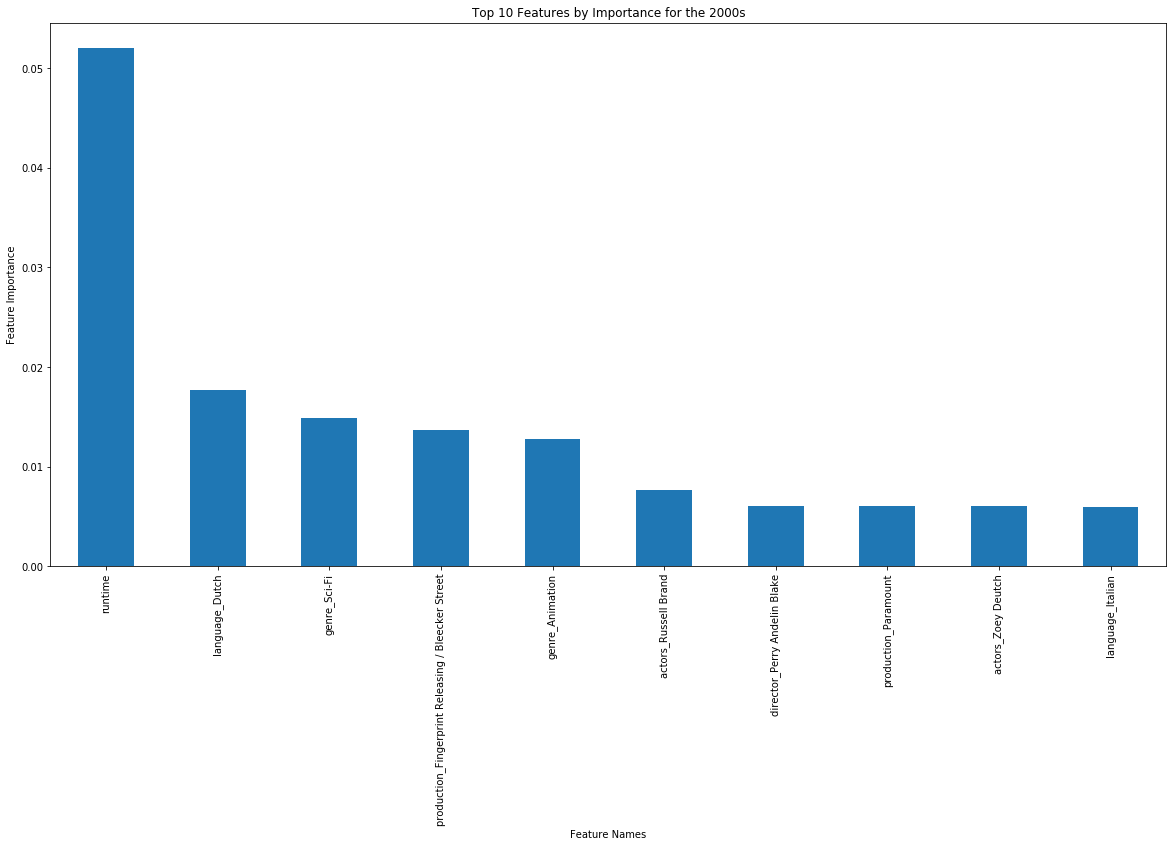

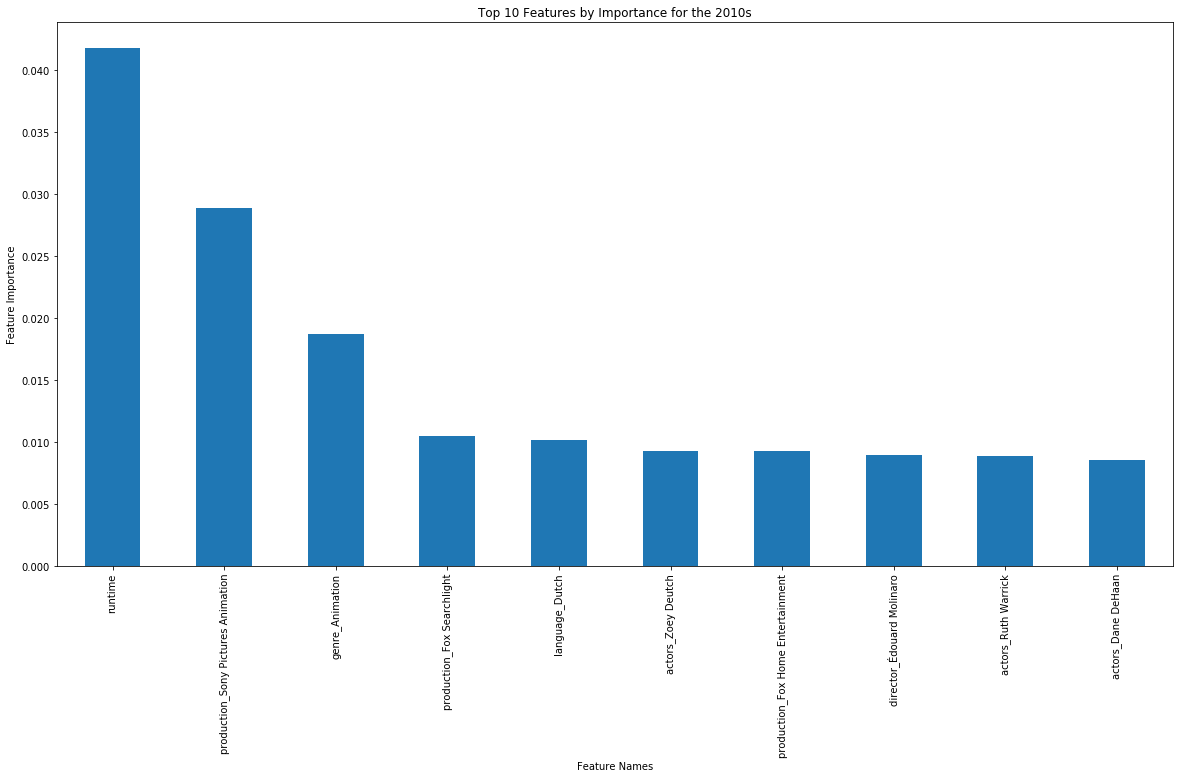

In [750]:
# Graph the features
top_of_decade_df = pd.DataFrame(top_of_decade)

for column in top_of_decade_df:
    graph_title = 'Top 10 Features by Importance for the ' + column.split('-')[0] + 's'
    
    fig, ax = plt.subplots(figsize=(20, 10)) 
        
    ax.set_xlabel('Feature Names')
    ax.set_ylabel('Feature Importance')
    ax.set_title(graph_title)
    
    top_of_decade_df[column].dropna().sort_values(ascending=False).plot.bar()